# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from tqdm import tqdm
import logging
import json
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from collections import Counter

In [4]:
project_root = os.path.abspath('..')
sys.path.insert(0, project_root)
from src.data.dataset import (
    PneumoniaDataset, 
    analyse_dataloader_classes, 
    debug_dataloader_labels
    )
from src.data.transforms import MedicalImageTransforms, create_data_transforms
from src.data.utils import (
    get_class_weights,
    get_balanced_sampling_weights,
    get_class_weights_tensor,
    get_data_statistics,
    print_dataset_statistics,
    show_batch,
    create_weighted_sampler
    )
from src.training.metrics import (
    TrainingTracker,
    ClassificationMetrics
    )
from src.training.trainer import train_model
from config import Config

Using device: cpu


# Set up plotting

In [5]:
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Device configuration

In [6]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
config = Config()
device = config.DEVICE
print(f"Device: {device}")
print(f"Data directory: {config.DATA_REDIST_DIR}")
print(f"Class names: {config.CLASS_NAMES}")
print(f"Number of epochs: {config.NUM_EPOCHS}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Learning rate: {config.LEARNING_RATE}")

Device: cpu
Data directory: /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/data/raw/redistributed
Class names: ['NORMAL', 'BACTERIA', 'VIRAL']
Number of epochs: 10
Batch size: 32
Learning rate: 0.001


# 2. Data validation

In [7]:
# Verify data structure and print statistics
print_dataset_statistics(config.DATA_REDIST_DIR)
print()

# Calculate class weights
weights_dict, counts_dict = get_class_weights(config.DATA_REDIST_DIR, use_training_only=True)


DATASET STATISTICS

TRAIN SET:
------------------------------
  NORMAL    :   900 images
  BACTERIA  :   900 images
  VIRAL     :   450 images
  TOTAL     :  2250 images

VAL SET:
------------------------------
  NORMAL    :   200 images
  BACTERIA  :   200 images
  VIRAL     :   100 images
  TOTAL     :   500 images

TEST SET:
------------------------------
  NORMAL    :   200 images
  BACTERIA  :   200 images
  VIRAL     :   100 images
  TOTAL     :   500 images



Processing train split:
  NORMAL: 900 images
  BACTERIA: 900 images
  VIRAL: 450 images

Class distribution and weights:
--------------------------------------------------
NORMAL: 900 images, weight: 0.833
BACTERIA: 900 images, weight: 0.833
VIRAL: 450 images, weight: 1.667
--------------------------------------------------
Total images: 2250


# 3. Data loading and preprocessing

In [8]:
# Define data transformations
data_transforms = create_data_transforms()

print("Data Transformations:")
print(f"Train: {data_transforms['train']}")
print(f"Validation: {data_transforms['val']}")
print(f"Test: {data_transforms['test']}")

Data Transformations:
Train: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
)
Validation: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
)
Test: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
)


In [9]:
# Create datasets
train_transform = data_transforms['train']
val_transform = data_transforms['val']
test_transform = data_transforms['test']

train_dataset = PneumoniaDataset(
    data_dir=config.DATA_REDIST_DIR,
    split_name='train',
    transform=train_transform,
    class_names=config.CLASS_NAMES
)

val_dataset = PneumoniaDataset(
    data_dir=config.DATA_REDIST_DIR,
    split_name='val',
    transform=val_transform,
    class_names=config.CLASS_NAMES
)

test_dataset = PneumoniaDataset(
    data_dir=config.DATA_REDIST_DIR,
    split_name='test',
    transform=test_transform,
    class_names=config.CLASS_NAMES
)

Found NORMAL images in train
Loaded 2250 images from train split
Class distribution in train:
  NORMAL: 900 images
  BACTERIA: 900 images
  VIRAL: 450 images
Found NORMAL images in val
Loaded 500 images from val split
Class distribution in val:
  NORMAL: 200 images
  BACTERIA: 200 images
  VIRAL: 100 images
Found NORMAL images in test
Loaded 500 images from test split
Class distribution in test:
  NORMAL: 200 images
  BACTERIA: 200 images
  VIRAL: 100 images


In [10]:
# Create balanced sampling for training
sampling_weights = get_balanced_sampling_weights(config.DATA_REDIST_DIR, use_training_only=True)

# Create sampler
sample_weights = []
for i in range(len(train_dataset)):
    image, label = train_dataset[i]  # Get the tuple (image, label)
    
    # Convert label to class name for weight lookup
    if isinstance(label, int):
        class_name = config.CLASS_NAMES[label]
    else:
        # If label is already a string/class name
        class_name = label
    sample_weights.append(sampling_weights[class_name])
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    sampler=sampler,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

print("DataLoaders created successfully!")


Processing train split:
  NORMAL: 900 images
  BACTERIA: 900 images
  VIRAL: 450 images

Class distribution and weights:
--------------------------------------------------
NORMAL: 900 images, weight: 0.833
BACTERIA: 900 images, weight: 0.833
VIRAL: 450 images, weight: 1.667
--------------------------------------------------
Total images: 2250
DataLoaders created successfully!


In [ ]:
############# NOT NECESSARY TO RUN #############
# First, debug to understand the label format
debug_dataloader_labels(train_loader, num_batches=1)

# Analyse dataloader composition
analyse_dataloader_classes(train_loader, config.CLASS_NAMES, num_batches=8)
analyse_dataloader_classes(val_loader, config.CLASS_NAMES, num_batches=8)

Debugging dataloader label format...
----------------------------------------

Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Labels type: <class 'torch.Tensor'>
  Labels: tensor([1, 0, 0, 1, 2, 1, 0, 2, 0, 2, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 2, 1])
  Labels shape: torch.Size([32])
  Labels dtype: torch.int64
  Labels as numpy: [1 0 0 1 2 1 0 2 0 2 1 1 2 2 1 1 0 1 2 2 1 1 1 1 0 1 0 0 0 0 2 1]
  Labels as numpy list: [1, 0, 0, 1, 2, 1, 0, 2, 0, 2, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 1]
    Label 0: <class 'torch.Tensor'> = 1
      Label 0 as int: 1
    Label 1: <class 'torch.Tensor'> = 0
      Label 1 as int: 0
    Label 2: <class 'torch.Tensor'> = 0
      Label 2 as int: 0
    Label 3: <class 'torch.Tensor'> = 1
      Label 3 as int: 1
    Label 4: <class 'torch.Tensor'> = 2
      Label 4 as int: 2
    Label 5: <class 'torch.Tensor'> = 1
      Label 5 as int: 1
    Label 6: <class 'torch.Tensor'> = 0
      Label 6 

Training Batch Samples:


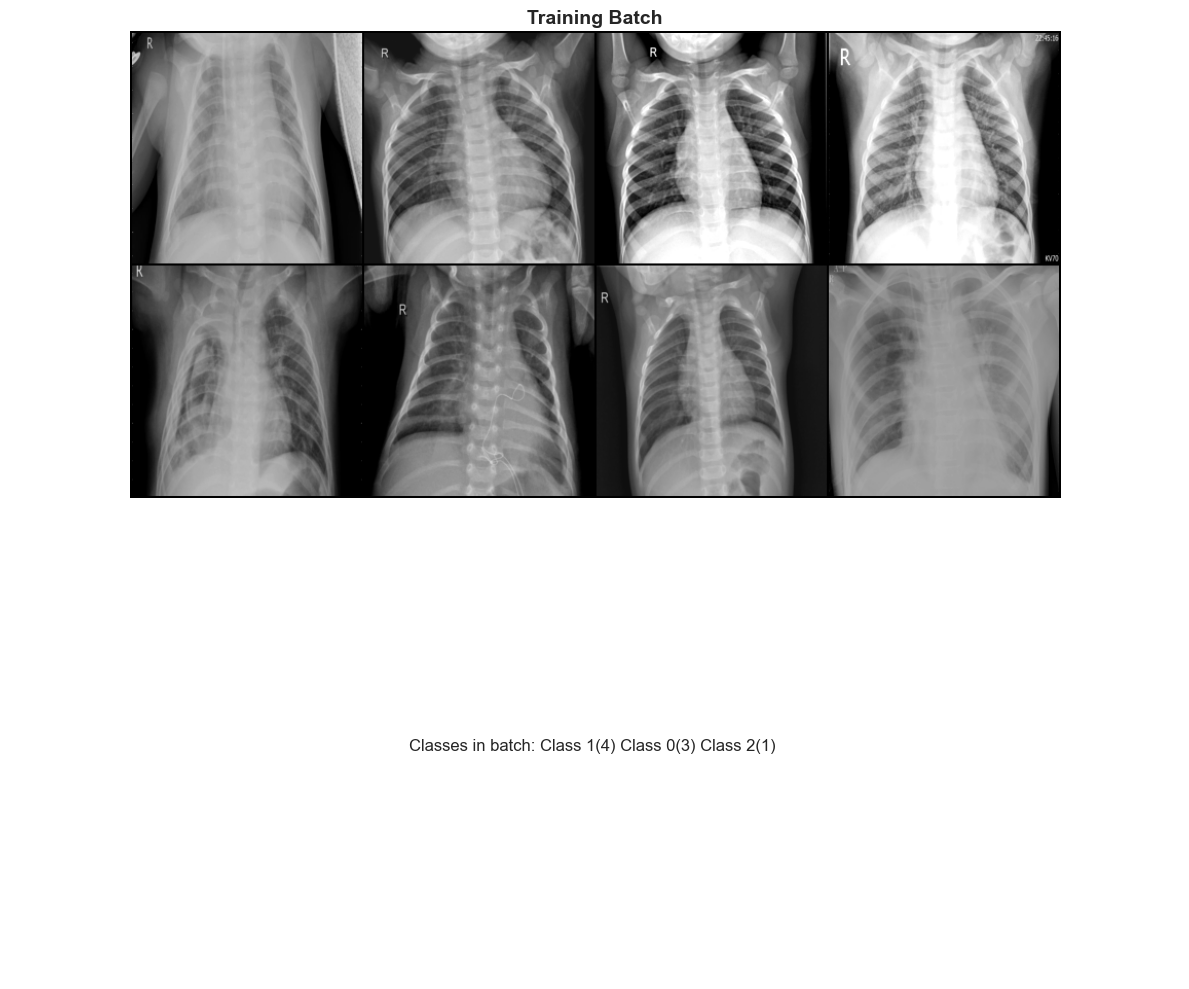


Training Batch
Total images: 32
Class distribution:
  Class 1: 4 images
  Class 0: 3 images
  Class 2: 1 images
Validation Batch Samples:


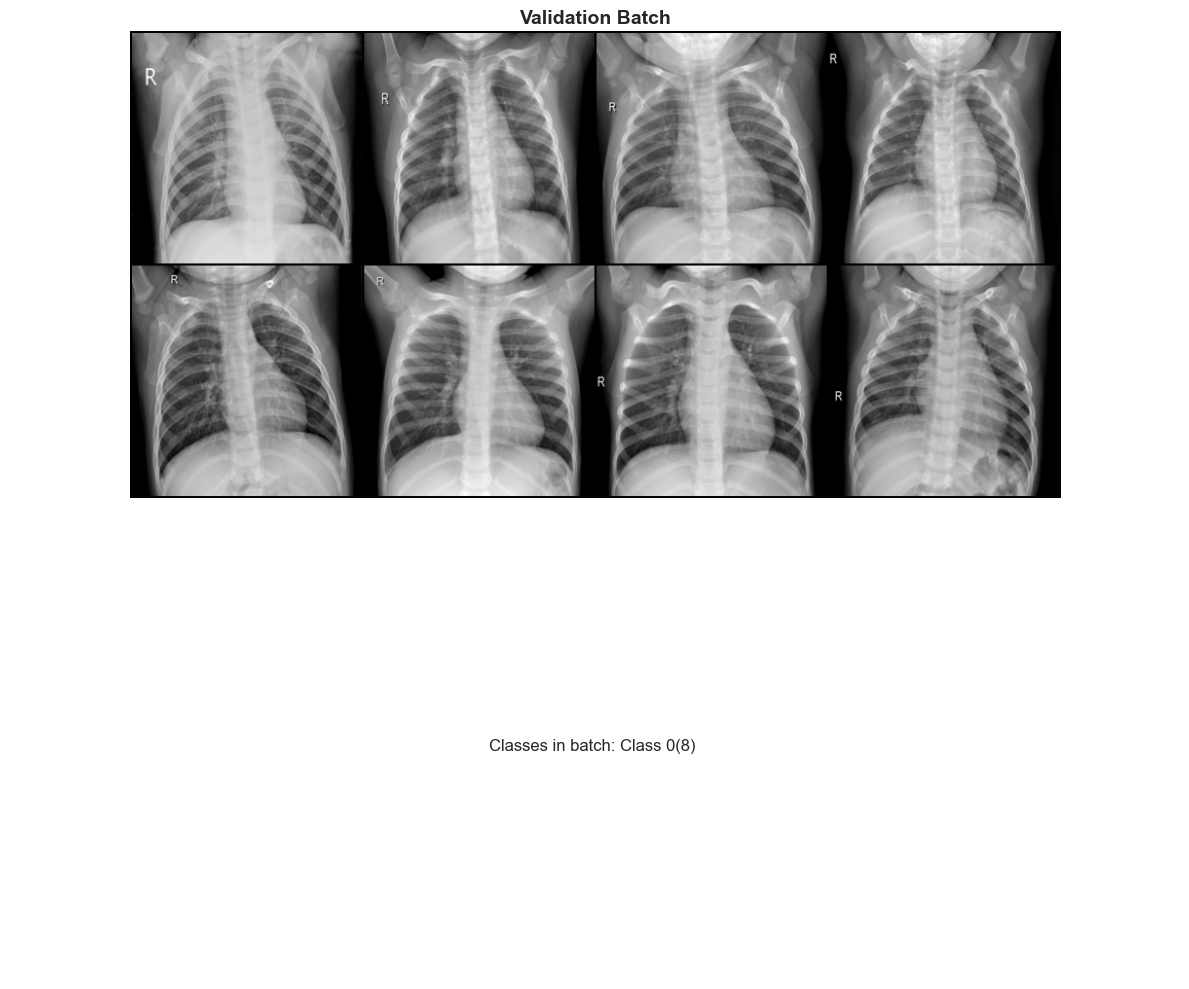


Validation Batch
Total images: 32
Class distribution:
  Class 0: 8 images


In [13]:
# VisualiSe sample batches
print("Training Batch Samples:")
show_batch(train_loader, num_images=8, title="Training Batch")

print("Validation Batch Samples:")
show_batch(val_loader, num_images=8, title="Validation Batch")

# 4. Model architecture

In [15]:
# Import model creation function
from src.models.transfer_learning import create_transfer_learning_model

# Create model
model = create_transfer_learning_model(config.MODEL_NAME, num_classes=config.NUM_CLASSES)
criterion = nn.CrossEntropyLoss() # Suitable for multi-class classification

print("Model Architecture:")
print(f"Model: {config.MODEL_NAME}")
print(f"Number of classes: {len(config.CLASS_NAMES)}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model Architecture:
Model: resnet18
Number of classes: 3
Total parameters: 11,308,611
Trainable parameters: 132,099


# 5. Training setup

In [16]:
# Loss function with class weights
device = torch.device(config.DEVICE)
class_weights_tensor = get_class_weights_tensor(config.DATA_REDIST_DIR, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

print(f"Loss Function: CrossEntropyLoss with class weights:")
for i, (class_name, weight) in enumerate(zip(config.CLASS_NAMES, class_weights_tensor)):
    print(f"  {class_name}: {weight:.3f}")


Processing train split:
  NORMAL: 900 images
  BACTERIA: 900 images
  VIRAL: 450 images

Class distribution and weights:
--------------------------------------------------
NORMAL: 900 images, weight: 0.833
BACTERIA: 900 images, weight: 0.833
VIRAL: 450 images, weight: 1.667
--------------------------------------------------
Total images: 2250
Loss Function: CrossEntropyLoss with class weights:
  NORMAL: 0.833
  BACTERIA: 0.833
  VIRAL: 1.667


In [31]:
# Optimiser and scheduler
optimiser = optim.Adam(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
    )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimiser,
    mode='min',
    patience=3,
    factor=0.1
    )

print(f"Optimiser: Adam (lr={config.LEARNING_RATE})")
print(f"Scheduler: ReduceLROnPlateau (patience=3, factor=0.1)")
# print(f"Initial learning rate from scheduler: {scheduler_last_lr}")

Optimiser: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau (patience=3, factor=0.1)


# 6. Training execution

In [ ]:
# Train the model using the existing trainer function
results = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimiser=optimiser,
    scheduler=scheduler,
    class_names=config.CLASS_NAMES,
    num_epochs=config.NUM_EPOCHS,
    patience=5,
    min_delta=0.001,
    save_path=f'{config.MODELS_DIR}/best_model.pth',
    device=device
)

print("Training completed!")

Starting training for 10 epochs...
Starting training for 10 epochs...
Device: cpu
Class names: ['NORMAL', 'BACTERIA', 'VIRAL']

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:55<00:00,  3.48s/it]


Train Loss: 0.7444 | Train Acc: 67.20%
Val Loss: 0.4993 | Val Acc: 81.80%
New best model saved to /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/models/best_model.pth

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:57<00:00,  3.61s/it]


Train Loss: 0.6043 | Train Acc: 74.31%
Val Loss: 0.5476 | Val Acc: 77.20%
Patience counter: 1/5

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it]


Train Loss: 0.6453 | Train Acc: 72.27%
Val Loss: 0.4686 | Val Acc: 80.60%
New best model saved to /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/models/best_model.pth

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]


Train Loss: 0.5502 | Train Acc: 77.20%
Val Loss: 0.4731 | Val Acc: 81.00%
Patience counter: 1/5

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it]


Train Loss: 0.5584 | Train Acc: 76.53%
Val Loss: 0.4708 | Val Acc: 80.80%
Patience counter: 2/5

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it]


Train Loss: 0.5826 | Train Acc: 75.11%
Val Loss: 0.5471 | Val Acc: 79.40%
Patience counter: 3/5

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it]


Train Loss: 0.5541 | Train Acc: 78.04%
Val Loss: 0.5107 | Val Acc: 78.40%
Patience counter: 4/5

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:54<00:00,  3.41s/it]


Train Loss: 0.5351 | Train Acc: 78.80%
Val Loss: 0.4604 | Val Acc: 82.20%
New best model saved to /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/models/best_model.pth

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:51<00:00,  3.23s/it]


Train Loss: 0.5243 | Train Acc: 77.64%
Val Loss: 0.4561 | Val Acc: 81.20%
New best model saved to /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/models/best_model.pth

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:51<00:00,  3.21s/it]

Train Loss: 0.5080 | Train Acc: 79.47%
Val Loss: 0.4739 | Val Acc: 79.00%
Patience counter: 1/5
Loaded best model with validation loss: 0.4561
Training completed!


# 7. Training results visualisation

INFO:root:Train Loss: 0.7444 | Train Acc: 67.20%
INFO:root:Val Loss: 0.4993 | Val Acc: 81.80%
INFO:root:Train Loss: 0.6043 | Train Acc: 74.31%
INFO:root:Val Loss: 0.5476 | Val Acc: 77.20%
INFO:root:Train Loss: 0.6453 | Train Acc: 72.27%
INFO:root:Val Loss: 0.4686 | Val Acc: 80.60%
INFO:root:Train Loss: 0.5502 | Train Acc: 77.20%
INFO:root:Val Loss: 0.4731 | Val Acc: 81.00%
INFO:root:Train Loss: 0.5584 | Train Acc: 76.53%
INFO:root:Val Loss: 0.4708 | Val Acc: 80.80%
INFO:root:Train Loss: 0.5826 | Train Acc: 75.11%
INFO:root:Val Loss: 0.5471 | Val Acc: 79.40%
INFO:root:Train Loss: 0.5541 | Train Acc: 78.04%
INFO:root:Val Loss: 0.5107 | Val Acc: 78.40%
INFO:root:Train Loss: 0.5351 | Train Acc: 78.80%
INFO:root:Val Loss: 0.4604 | Val Acc: 82.20%
INFO:root:Train Loss: 0.5243 | Train Acc: 77.64%
INFO:root:Val Loss: 0.4561 | Val Acc: 81.20%
INFO:root:Train Loss: 0.5080 | Train Acc: 79.47%
INFO:root:Val Loss: 0.4739 | Val Acc: 79.00%


Starting training for 10 epochs...
Populating tracker with existing results...


INFO:root:Training history plot saved to /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/results/training_history.png


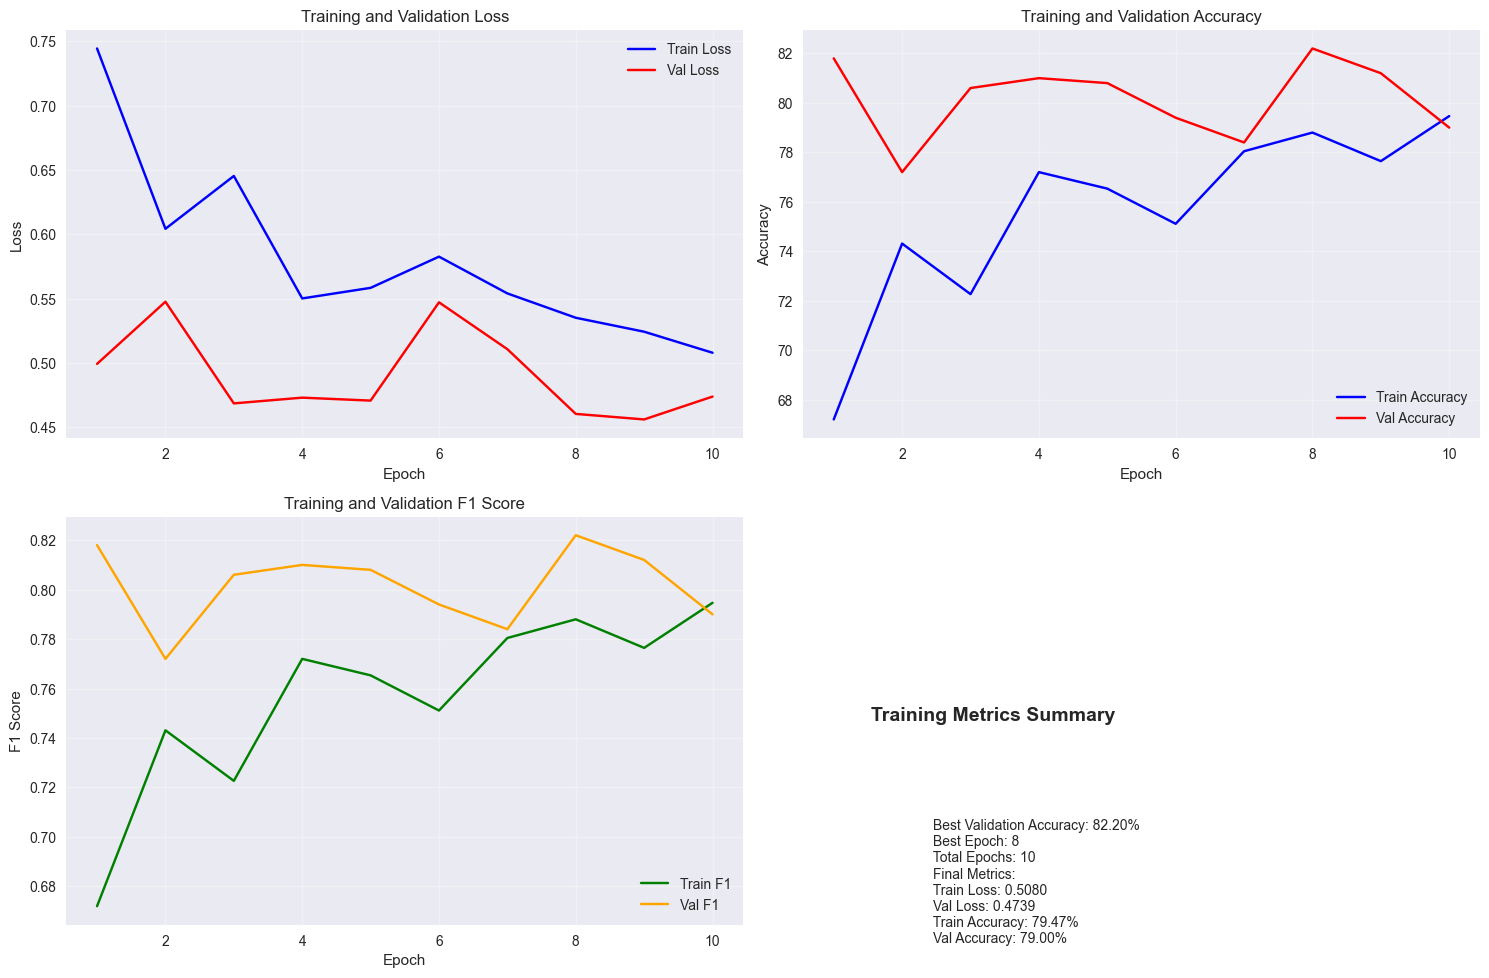

INFO:root:Metrics summary saved to /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/results/metrics_summary.txt


Training tracker populated successfully!
Tracked 10 epochs
Best validation accuracy: 82.20%


In [42]:
# 1. Initialise training tracker
tracker = TrainingTracker(save_dir=config.RESULTS_DIR)

print(f"Starting training for {config.NUM_EPOCHS} epochs...")
print("=" * 60)

# 2. Populate with existing results
print("Populating tracker with existing results...")
for epoch in range(len(results['train_losses'])):
    train_metrics = {
        'avg_loss': results['train_losses'][epoch],
        'accuracy': results['train_accs'][epoch],
        'f1': results['train_accs'][epoch] / 100,
        'precision': results['train_accs'][epoch] / 100,
        'recall': results['train_accs'][epoch] / 100,
        'epoch': epoch + 1
    }
    
    val_metrics = {
        'avg_loss': results['val_losses'][epoch],
        'accuracy': results['val_accs'][epoch],
        'f1': results['val_accs'][epoch] / 100,
        'precision': results['val_accs'][epoch] / 100,
        'recall': results['val_accs'][epoch] / 100,
        'epoch': epoch + 1
    }
    
    tracker.update_epoch(train_metrics, val_metrics)

# 3. Generate visualisations
tracker.plot_training_history(save_dir=config.RESULTS_DIR)
tracker.save_metrics_summary(save_dir=config.RESULTS_DIR)

print("Training tracker populated successfully!")
print(f"Tracked {len(results['train_losses'])} epochs")
print(f"Best validation accuracy: {max(results['val_accs']):.2f}%")


# 8. Evaluation

In [17]:
# Import all evaluation functions
from src.evaluation.evaluator import (evaluate_model_comprehensive,
                                      generate_predictions_file,
                                      save_predictions_analysis)
from src.evaluation.visualisations import (create_evaluation_plots, 
                                           create_comprehensive_analysis,
                                           plot_confusion_matrix,
                                           plot_roc_curve,
                                           get_best_class,
                                           get_worst_class)
from src.evaluation.save_eval import (print_evaluation_results,
                                      save_evaluation_results,
                                      print_evaluation_summary)

In [15]:
from src.models.transfer_learning import create_resnet18_eval

# Load best model
best_model_path = f'{config.MODELS_DIR}/best_model.pth'
checkpoint = torch.load(best_model_path, map_location=device)

print(f"Loaded model from epoch {checkpoint['epoch']}")
print(f"Validation accuracy: {checkpoint['val_acc']:.2f}%")

# Create model with pretrained=False for evaluation
model = create_resnet18_eval(num_classes=len(config.CLASS_NAMES), pretrained=False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()  # Set to evaluation mode


Loaded model from epoch 8
Validation accuracy: 81.20%


/opt/miniconda3/envs/torchpy311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/torchpy311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# 1. Create test DataLoader
# test_loader has been created above

# 2. Run comprehensive evaluation
final_metrics, metrics_calculator = evaluate_model_comprehensive(
    model=model, # loaded evaluation model
    dataloader=test_loader,
    class_names=config.CLASS_NAMES,
    device=device,
    save_dir=config.RESULTS_DIR
    )

# 3. Generate predictions file
predictions_file = generate_predictions_file(
    model=model,
    dataloader=test_loader,
    class_names=config.CLASS_NAMES,
    device=device,
    save_dir=config.PREDICTIONS_DIR
    )

Evaluating model on 16 batches...


Evaluating: 100%|██████████| 16/16 [00:57<00:00,  3.57s/it]


Metrics calculator saved to: /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/results/metrics_calculator.pkl
Evaluation results saved to: /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/results
  - JSON results: /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/results/detailed_evaluation_results.json
  - Text report: /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/results/evaluation_report.txt
  - Metrics calculator: /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/results/metrics_calculator.pkl
Generating detailed predictions...


Generating predictions: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it]

Predictions saved to: /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/predictions/predictions.csv
Analysis saved to: /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/predictions/predictions_analysis.txt


Creating evaluation plots...


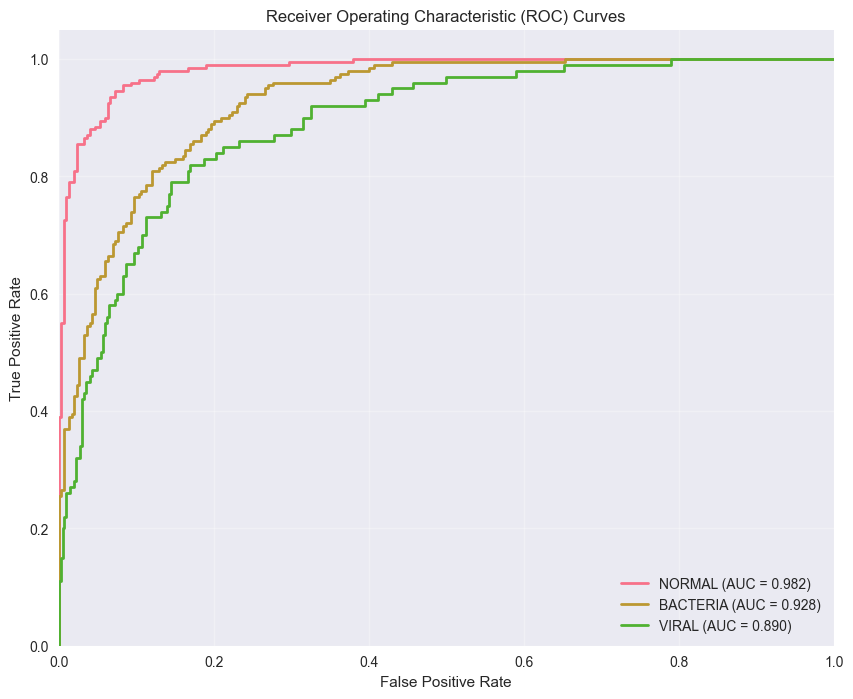

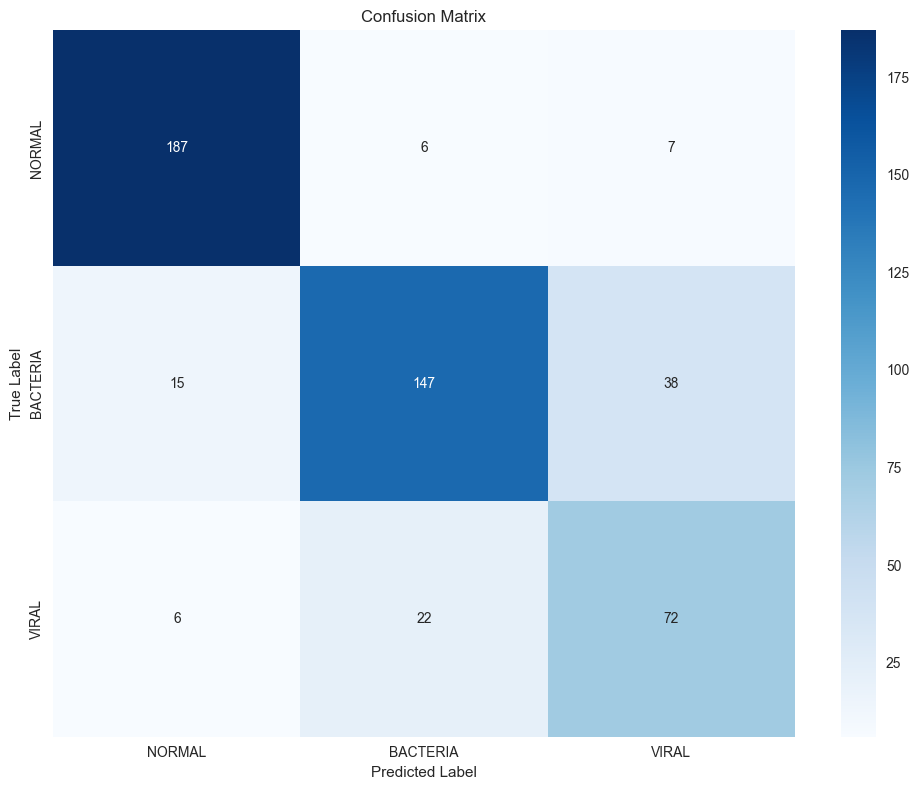

=== MODEL PERFORMANCE SUMMARY ===
Accuracy: 0.8120
Precision (Macro): 0.7848
Recall (Macro): 0.7967
F1 Score (Macro): 0.7881
ROC AUC (Macro): 0.9334

=== PER-CLASS PERFORMANCE ===
NORMAL:
  Precision: 0.8990
  Recall: 0.9350
  F1 Score: 0.9167
  Support: 200.0 samples
BACTERIA:
  Precision: 0.8400
  Recall: 0.7350
  F1 Score: 0.7840
  Support: 200.0 samples
VIRAL:
  Precision: 0.6154
  Recall: 0.7200
  F1 Score: 0.6636
  Support: 100.0 samples


In [21]:
# 4. Create visualiser from existing metrics_calculator
from src.evaluation.metrics import ClassificationMetrics
visualiser = ClassificationMetrics(metrics_calculator)

print("Creating evaluation plots...")
# 5. ROC Curve
visualiser.plot_roc_curve(save_path=None)  # Display in notebook

# 6. Confusion Matrix
visualiser.plot_confusion_matrix(save_path=None)  # Display in notebook

# 7. Precision-Recall Curve
visualiser.plot_precision_recall_curve(save_path=None)  # Display in notebook

# 8. Print summary
visualiser.print_summary()

INFO:root:Multi-class ROC curves saved to /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/results/plots/roc_curve.png


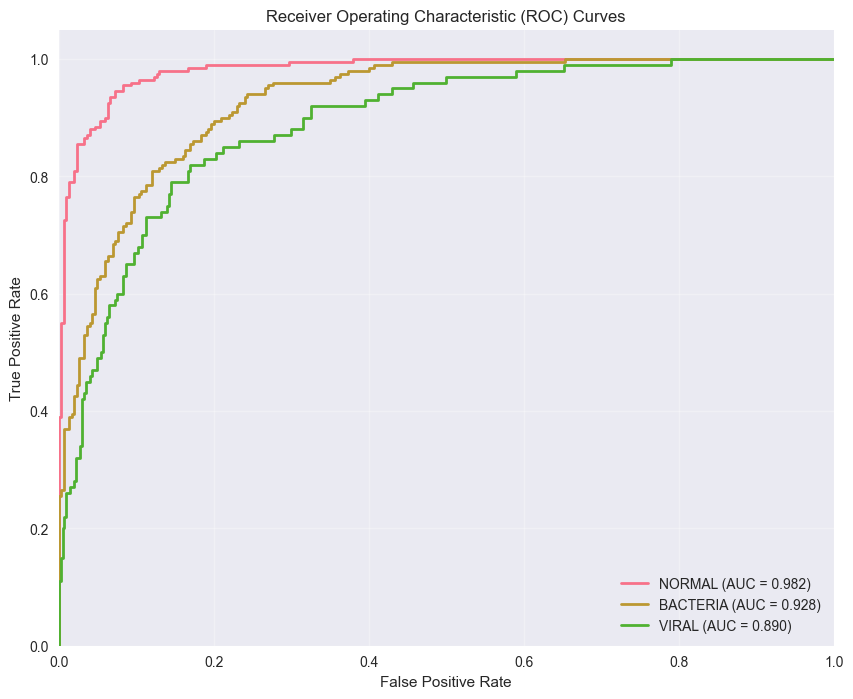

INFO:root:Confusion matrix saved to /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/results/plots/confusion_matrix.png


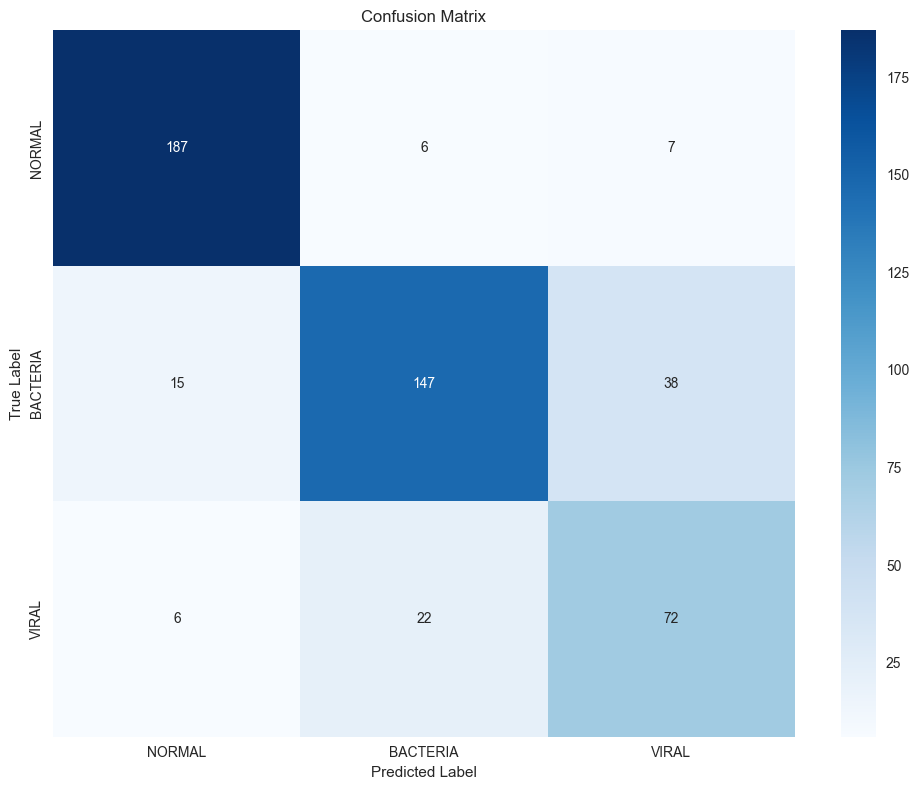

INFO:root:Summary saved to: /Users/intankwardhani/Documents/BeCode/pneumonia-detection-cnn/outputs/results/evaluation_summary.txt


In [23]:
# Save plots
plots_dir = os.path.join(config.RESULTS_DIR, 'plots')
os.makedirs(plots_dir, exist_ok=True)

# ROC Curve
visualiser.plot_roc_curve(save_path=f"{plots_dir}/roc_curve.png")

# Confusion Matrix
visualiser.plot_confusion_matrix(save_path=f"{plots_dir}/confusion_matrix.png")

# Save summary
visualiser.save_summary(save_path=f"{config.RESULTS_DIR}/evaluation_summary.txt")